
# Set up environment

In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import torchtext 

print(torchtext.__version__)
# from torchtext.data import *
from torchtext.legacy import *
from torchtext.legacy.data import *
import nltk
nltk.download('punkt')
from nltk import word_tokenize
plt.style.use('seaborn')

0.10.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
datapath = "/content/drive/MyDrive/IMPRS/dlcv/data/MELD/"
train_df = pd.read_csv(datapath + "train_sent_emo.csv")
test_df = pd.read_csv(datapath + "test_sent_emo.csv")
train_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [ ]:
test_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. That’s so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"
...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211"
2606,2761,They’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840"
2607,2762,Of course they’re listening to you! Everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511"
2608,2763,Monica you really think I should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390"


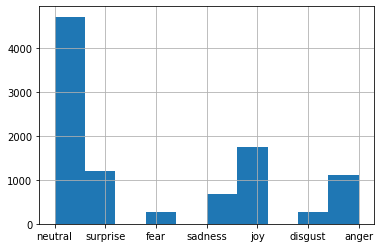

In [ ]:
train_df['Emotion'].hist()

# Preprocessing

In [ ]:
train_df[['Emotion']] = train_df[['Emotion']].apply(LabelEncoder().fit_transform) 
test_df[['Emotion']] = test_df[['Emotion']].apply(LabelEncoder().fit_transform) 


In [ ]:
df2 = train_df.drop(train_df.columns[[0,2,4,5,6,7,8,9,10]],axis=1)
df3 = test_df.drop(train_df.columns[[0,2,4,5,6,7,8,9,10]],axis=1)
# df2 = df2.drop(train_df.columns[[1]],axis=1)

df2

,Utterance,Emotion
0,also I was the point person on my company’s tr...,4
1,You must’ve had your hands full.,4
2,That I did. That I did.,4
3,So let’s talk a little bit about your duties.,4
4,My duties? All right.,6
...,...,...
9984,You or me?,4
9985,"I got it. Uh, Joey, women don't have Adam's ap...",4
9986,"You guys are messing with me, right?",6
9987,Yeah.,4


In [ ]:
df2.to_csv(datapath + "train_sent_emo_processed.csv")
df3.to_csv(datapath + "test_sent_emo_processed.csv")

# Dataloader

In [ ]:
# defining txt and label object type (container, not actual data)
txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)
id_field = data.Field(sequential=False, use_vocab=False, batch_first=True)

In [ ]:
full= TabularDataset(path=datapath + "train_sent_emo_processed.csv",format='csv', 
                                  fields=[('id',id_field), ('text', txt_field), ('label', label_field)], skip_header=True)
txt_field.build_vocab(full, min_freq=5)

test_full= TabularDataset(path=datapath + "test_sent_emo_processed.csv",format='csv', 
                                  fields=[('id',id_field), ('text', txt_field), ('label', label_field)], skip_header=True)

#label_field.build_vocab(full)

In [ ]:
import math
full_iter = data.Iterator(full, batch_size = 30)

min_vocab =  math.inf
max_vocab = 0
max_len = 0
cnt = 0
for i in full_iter:
  tex, tex_len = i.text
  max_tex_len=torch.max(tex_len).item()
  vocab = torch.max(tex).item()
  vocab_low = torch.min(tex).item()
  #print('max_tex_len=',max_tex_len)
  #print('vocab=',vocab)
  if max_vocab < vocab:
    max_vocab = vocab
  if max_len < max_tex_len:
    max_len = max_tex_len
  if min_vocab > vocab_low:
    min_vocab = vocab_low
  cnt+=1
print(max_len)
print(max_vocab)
print(min_vocab)
#print(cnt)

91
1270
0


In [ ]:
full_iter = data.Iterator(test_full, batch_size = 30)

min_vocab =  math.inf
max_vocab = 0
max_len = 0
cnt = 0
for i in full_iter:
  tex, tex_len = i.text
  max_tex_len=torch.max(tex_len).item()
  vocab = torch.max(tex).item()
  vocab_low = torch.min(tex).item()
  #print('max_tex_len=',max_tex_len)
  #print('vocab=',vocab)
  if max_vocab < vocab:
    max_vocab = vocab
  if max_len < max_tex_len:
    max_len = max_tex_len
  if min_vocab > vocab_low:
    min_vocab = vocab_low
  cnt+=1
print(max_len)
print(max_vocab)
print(min_vocab)
#print(cnt)

56
1270
0


In [ ]:
# make iterator for splits
train, vali = full.split(split_ratio=0.8)
train_iter, vali_iter,test_iter = data.BucketIterator.splits((train,vali,test_full), batch_size=30, 
                                                   sort_key=lambda x: len(x.text),sort_within_batch=True)


# Define baseline model


In [ ]:
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F

class simple_RNN(nn.Module):
    def __init__(self,n_vocab,n_class, embedding_dim, n_hidden, n_layers, dropout):
        super(simple_RNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.RNN(
                input_size=embedding_dim,
                hidden_size=embedding_dim,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True
        )
        self.fc0 = nn.Linear( embedding_dim, embedding_dim)
        self.fc = nn.Linear( embedding_dim, n_class)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, sent):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = F.relu(self.emb(sent)) #batch_size, max_sent_len, embedding_dim
        #x, y, z = sent_emb.shape
        #sent_emb = sent_emb[:,-1,:]
        
        # method 1
        rnn_out, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        rnn_out = rnn_out[:, -1,:]
        x = F.relu(self.fc0(rnn_out))   # batch_size, 
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc0(x))
        prob = self.sigmoid(self.fc(x))

        #output = ( prob > 0.5 ).float()
        return prob

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

Current device: cuda:0


In [ ]:
# define parameters
n_vocab = max_vocab +1
embedding_dim = 200

n_hidden = 128
n_layers = 8
dropout = 0.
n_class = 7
#lr = 0.001

# build model
criterion = torch.nn.CrossEntropyLoss()
model = simple_RNN( n_vocab,n_class, embedding_dim, n_hidden, n_layers, dropout).to(device)
#optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(model)

The model architecture:

 simple_RNN(
  (emb): Embedding(1271, 200)
  (rnn): RNN(200, 200, num_layers=8, batch_first=True)
  (fc0): Linear(in_features=200, out_features=200, bias=True)
  (fc): Linear(in_features=200, out_features=7, bias=True)
  (sigmoid): Sigmoid()
)

The model has 939,007 trainable parameters


# Training

In [ ]:
# training helper function 

def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [ ]:
# main training function 

def TRAIN(model, train_iter, valid_iter,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name):
    
    running_loss = 0.0
    global_step = 0
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
    train_loss_ls=[]
    val_loss_ls=[]
    model.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i in train_iter:
            inputs, inputs_len = i.text
            #dim1, dim2 = inputs.shape
            #print('inputs',inputs.shape)
            #if dim1 != 30:
              #continue
            labels = i.label
            model.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = model(inputs)
            #loss = criterion(outputs[:,-1,:], labels[:,-1,:])
            #print('inputs',inputs.shape)
            #print('outputs',outputs[:,-1].shape)
            #print('labels',labels.shape)
            labels = torch.tensor(labels, dtype=torch.long)
            loss = criterion(outputs, labels)
            #loss.requres_grad = True

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1

            running_loss += loss.item()

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    model.eval()
                    val_running_loss = 0.0
                    num=0
                    for j in vali_iter:
                        val_inputs, val_inputs_len = j.text
                        val_labels = j.label
                        val_labels = torch.tensor( val_labels, dtype=torch.long)
                        val_inputs = val_inputs.to(device)
                        val_labels = val_labels.to(device)
                        val_outputs =  model(val_inputs)
                        #val_loss = criterion(val_outputs[:,-1,:], val_labels[:,-1,:])
                        val_loss = criterion(val_outputs, val_labels)
                        val_running_loss += val_loss.item()
                        num+=1

                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / num

                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}' 
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss, average_val_loss))
                    train_loss_ls.append(average_train_loss)
                    val_loss_ls.append(average_val_loss)
                    running_loss = 0.0
                    if average_val_loss < best_val_loss:
                        best_val_loss = average_val_loss
                        save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    np.save('/content/drive/My Drive/cnn/train_loss.npy',train_loss_ls)
    np.save('/content/drive/My Drive/cnn/val_loss.npy',val_loss_ls)                
    print('Finished Training')

In [ ]:
n_epochs = 15
val_loss = None
save_name = '/content/drive/My Drive/kaggle_rnn/simple_rnn_model'
eval_every = 200
total_step = len(train)*n_epochs
optimizer = SGD(model.parameters(), lr=0.0004, momentum=0.9)

#start training
TRAIN(model, train_iter, vali_iter,  n_epochs, 
      eval_every, total_step, criterion, optimizer, val_loss, device, save_name)

<ipython-input-145-934a7172928b>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-145-934a7172928b>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor( val_labels, dtype=torch.long)


Epoch [1/15], Step [200/119865], Train Loss: 1.9419, Valid Loss: 1.9365
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [2/15], Step [400/119865], Train Loss: 1.9311, Valid Loss: 1.9253
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [3/15], Step [600/119865], Train Loss: 1.9205, Valid Loss: 1.9139
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [3/15], Step [800/119865], Train Loss: 1.9082, Valid Loss: 1.9016
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [4/15], Step [1000/119865], Train Loss: 1.8965, Valid Loss: 1.8886
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [5/15], Step [1200/119865], Train Loss: 1.8824, Valid Loss: 1.8741
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_model
Epoch [6/15], Step [1400/119865], Train Loss: 1.8683, Valid Loss: 1.8580
Model saved to ==> /content/drive/My Drive/kaggle_rnn/simple_rnn_mo

# Plot training result

In [ ]:
def plot(model, dataloader):
    true = []
    pred = []
    with torch.no_grad():
        model.eval()
        for inputs, labels in dataloader:
            outputs = model(inputs)
            true.append(labels.numpy().reshape(-1)[-1])
            pred.append(outputs.detach().numpy().reshape(-1)[-1])
    return true, pred

In [ ]:
optimizer = SGD(model.parameters(), lr=0.0004, momentum=0.9)
load_checkpoint(model, optimizer, save_name)

Model loaded from <== /content/drive/My Drive/kaggle_rnn/simple_rnn_model


1.672401855241007

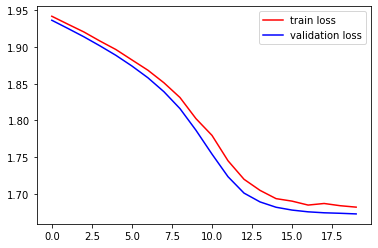

In [ ]:
train_loss=np.load('/content/drive/My Drive/cnn/train_loss.npy')
val_loss=np.load('/content/drive/My Drive/cnn/val_loss.npy')
t= np.arange(len(train_loss))
plt.plot(t,train_loss,c='red',label='train loss')
plt.plot(t,val_loss,c='blue',label='validation loss')
plt.legend()
plt.savefig(datapath + 'loss.png')

# Test prediction

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve


for i in test_iter:
  lab = i.label
  text, len_text = i.text

predict = model(text.to(device))
print(predict.shape)
print(lab.shape)
pred = (predict.argmax(axis=1)).float()

torch.Size([30, 7])
torch.Size([30])


In [ ]:
pred = pred.cpu()
print(pred)
print(lab)

tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])
tensor([3, 0, 4, 4, 0, 4, 0, 4, 4, 5, 5, 4, 4, 0, 4, 4, 2, 4, 4, 6, 5, 4, 4, 5,
        3, 5, 4, 6, 0, 4])


In [ ]:
print(classification_report(lab, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.50      1.00      0.67        15
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2

    accuracy                           0.50        30
   macro avg       0.08      0.17      0.11        30
weighted avg       0.25      0.50      0.33        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM model

In [ ]:
class simple_LSTM(nn.Module):
    def __init__(self,n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(simple_LSTM, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)
        self.rnn = nn.RNN(
                input_size=embedding_dim,
                hidden_size=embedding_dim,
                num_layers=n_layers,
                dropout=dropout,
                batch_first=True
        )
        self.fc = nn.Linear( embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent):
        # sent: batch_size, max_sent_len
        # sent_len: batch_size
        
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        #x, y, z = sent_emb.shape
        #sent_emb = sent_emb[:,-1,:]
        
        # method 1
        rnn_out, hidden = self.rnn(sent_emb)
        
        # method 2, pack the input sequence, more computationally efficient
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, src_len, batch_first=True)
        #packed_outputs, hidden = self.rnn(packed_embedded)
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        
        #output: batch_size, max_sent_len, n_hidden
        #hidden: n_layer, batch_size, n_hidden 
        rnn_out = rnn_out[:, -1,:]
        prob = self.sigmoid(self.fc(rnn_out))   # batch_size, 
        #output = ( prob > 0.5 ).float()
        return prob